In [ ]:
#!pip install nltk
#!conda install -c anaconda nltk

In [25]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import re
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
from string import digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from nltk.tokenize import RegexpTokenizer, regexp_tokenize, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [2]:
df = pd.read_csv('Data/Phase4_tweet_dataset.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.dropna(inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          3291 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  3291 non-null   object
dtypes: object(3)
memory usage: 102.8+ KB


In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df = df.drop(df[(df.is_there_an_emotion_directed_at_a_brand_or_product != "Positive emotion") 
          & (df.is_there_an_emotion_directed_at_a_brand_or_product != "Negative emotion")].index)

In [8]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

Positive emotion    2672
Negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
sw = stopwords.words('english')


In [10]:
sw.extend(["i'd", "i'm", "w", "@mention", "#sxswrt", "#ipad", "#apple", "u", "#sxsw", "sxsw", "mention", "ipad", "apple", "iphone", "link", "rt", "google", "quot", "linkrt", "amp", "austin"])

In [11]:
##Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
### need to remove numeric values 
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    
#     tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
#     doc = tweet_tokenizer.tokenize(doc)
    
    doc = [word for word in doc if word not in sw] #getting rid of stopwords
    doc = [word for word in doc if string.punctuation.find(word) == -1] #getting rid of punctuation
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]

    lemmatizer = WordNetLemmatizer() #lemmatizing
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc] 
    doc = [re.sub(r"\d+", "", word) for word in doc] #getting rid of numeric values

    return ' '.join(doc)

In [13]:
# #adding '...' to punctuation string
# string.punctuation += '...'
# string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...'

In [13]:
df['clean_tweets'] = df['tweet_text'].apply(doc_preparer)

In [14]:
#body of text
corpus = ''
for i in df['clean_tweets'][:]:
    corpus += i

''

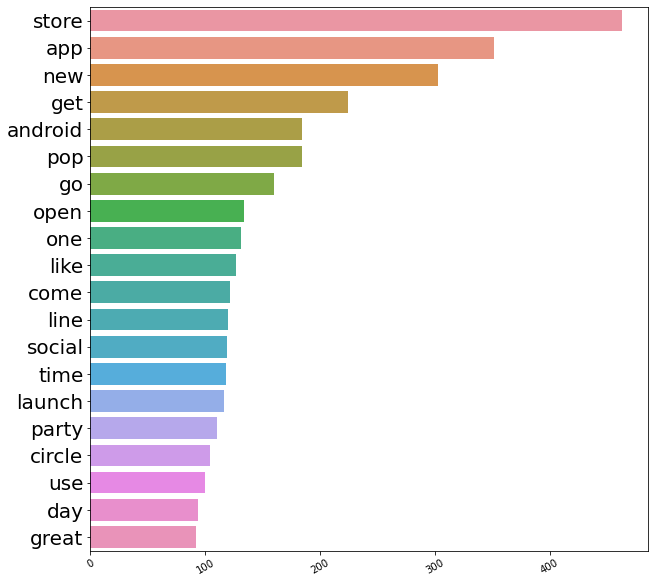

In [44]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(corpus.split()).most_common(20)
## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))
## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax, orient='h')
plt.xticks(rotation=30)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=20) 
plt.savefig('clean_tweets_distro')
;


In [18]:
#body of text
stopwords_count = []
for i in df['tweet_text'][:]:
    for word in i.split():
        if word in sw:
            stopwords_count.append(word)


''

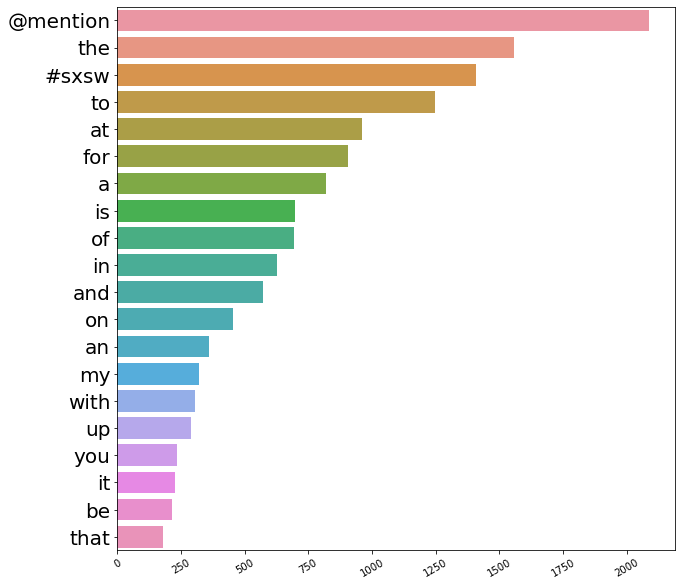

In [43]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens

all_fdist = FreqDist(stopwords_count).most_common(20)
## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))
## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax, orient='h')
plt.xticks(rotation=30)

plt.savefig('stopwords_distro')
;

In [50]:
X = df.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product', 'tweet_text'], axis =1)
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [52]:
cv = CountVectorizer(input='content') #ngram_range=(3, 500)

In [53]:
X_train_vec = cv.fit_transform(X_train['clean_tweets'])
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [54]:
X_test_vec = cv.transform(X_test['clean_tweets'])
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)


In [55]:
#Dummy classifier
dc = DummyClassifier(strategy='stratified')
dc.fit(X_train_vec, y_train)

print(cross_val_score(dc, X_train_vec, y_train).mean())

0.7208663446336072


In [168]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
mnb_pred = mnb.predict(X_test_vec)
print(cross_val_score(mnb, X_train_vec, y_train).mean())

0.844127846542221


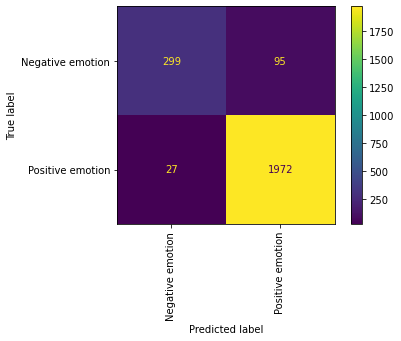

In [57]:
plot_confusion_matrix(mnb, X_train_vec, y_train, xticks_rotation='vertical');

In [165]:
#overfitted model - might change penalty to l1
sgd = SGDClassifier(penalty='l1', alpha=1e-3, random_state=42, max_iter=5, tol=None, n_iter_no_change=20)
sgd.fit(X_train_vec, y_train)
sgd_pred = sgd.predict(X_train_vec)
sgd_pred_test = sgd.predict(X_test_vec)
print("Cross validation", cross_val_score(sgd, X_train_vec, y_train).mean())
print("Recall", recall_score(y_train, sgd_pred, average='weighted'))
print("Accuracy", accuracy_score(y_train, sgd_pred))

Cross validation 0.858345926398267
Recall 0.8896782281654827
Accuracy 0.8896782281654827


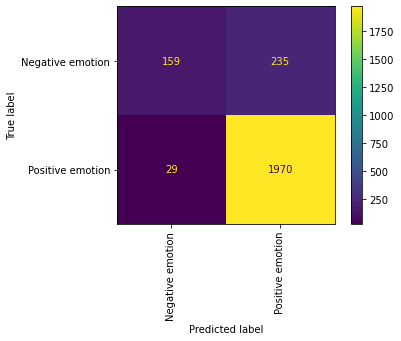

In [163]:
#overfitted
plot_confusion_matrix(sgd, X_train_vec, y_train, xticks_rotation='vertical');

In [ ]:
# pip install wordcloud

In [20]:
positive_tweets = df[df['is_there_an_emotion_directed_at_a_brand_or_product']  == 'Positive emotion']['clean_tweets']

In [21]:
#body of text
corpus_pos = ''
for i in positive_tweets:
    corpus_pos += i

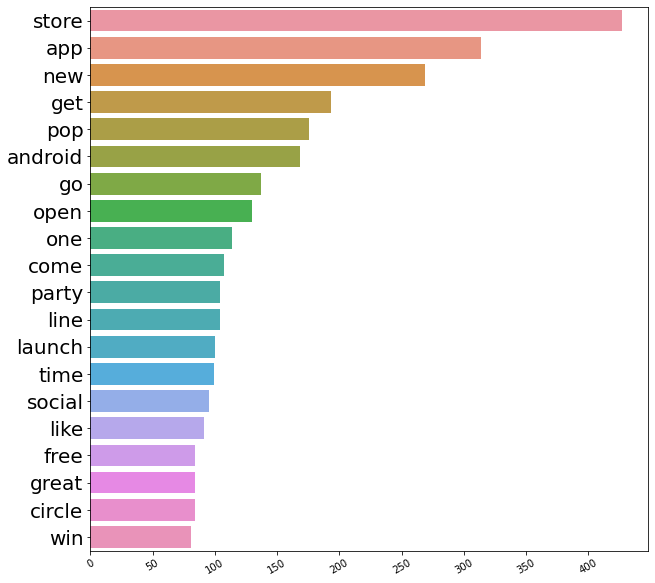

In [45]:
all_fdist1 = FreqDist(corpus_pos.split()).most_common(20)
## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist1 = pd.Series(dict(all_fdist1))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))
## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist1.index, x=all_fdist1.values, ax=ax, orient='h')
plt.xticks(rotation=30)

plt.savefig('pos_words_distro');

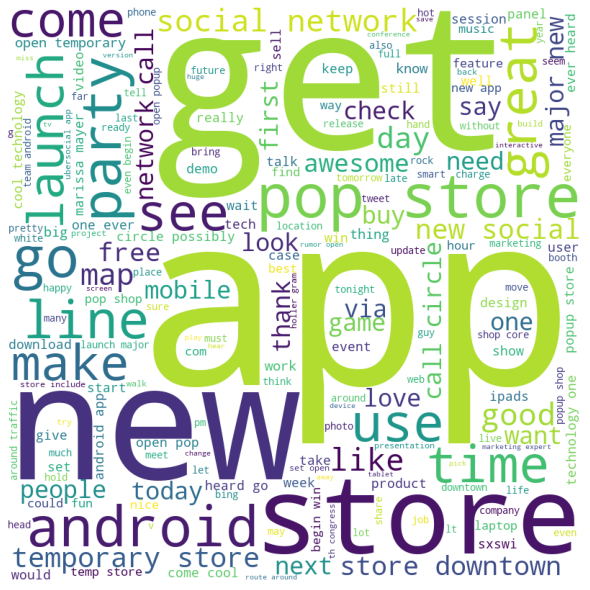

<Figure size 432x288 with 0 Axes>

In [46]:
# Python program to generate WordCloud
 
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = sw,
                min_font_size = 10).generate(corpus_pos)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
plt.savefig('pos_word_map');

In [84]:
X_train_ind = X_train_vec.reset_index(drop=True)
y_train_ind = y_train.reset_index(drop= True)

In [85]:
X_train_vec.shape

(2393, 3921)

In [86]:
y_train_inds = y_train_ind.to_numpy()
y_train_inds

array(['Positive emotion', 'Positive emotion', 'Positive emotion', ...,
       'Positive emotion', 'Negative emotion', 'Positive emotion'],
      dtype=object)

In [87]:
X_train_inds = X_train_ind.to_numpy()

In [88]:
smote = SMOTE(random_state = 11, sampling_strategy='auto')
X_train_sm, y_train_sm = smote.fit_resample(X = X_train_inds, y = y_train_inds)

In [89]:
X_train_sm.shape

(3998, 3921)

In [90]:
y_train_sm.shape

(3998,)

In [91]:
sgd1 = SGDClassifier(penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=None)
sgd1.fit(X_train_sm, y_train_sm)
sgd_pred1 = sgd1.predict(X_test_vec)
print("Recall", recall_score(y_test, sgd_pred1, average='weighted'))
print("Accuracy", accuracy_score(y_test, sgd_pred1))

Recall 0.8170426065162907
Accuracy 0.8170426065162907


In [120]:
from sklearn.ensemble import ExtraTreesClassifier

In [121]:
etc = ExtraTreesClassifier()
etc.fit(X_train_vec, y_train)


ExtraTreesClassifier()

In [123]:
cross_val_score(etc, X_train_vec, y_train).mean()

0.8783972886330481

In [124]:
y_pred_etc = etc.predict(X_test_vec)

In [127]:
y_pred_etc_train = etc.predict(X_train_vec)

In [128]:
accuracy_score(y_train, y_pred_etc_train)

0.9983284580025074

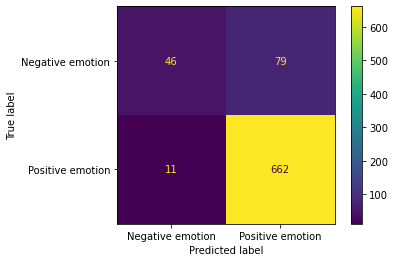

In [129]:
plot_confusion_matrix(etc, X_test_vec, y_test)

In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
grid = {'n_estimators':range(100, 120), 'criterion': ["gini", "entropy"], 'min_samples_split':range(2,5)}

etcgrid = GridSearchCV(estimator=etc, param_grid=grid, cv=5, n_jobs=-4, verbose=3)
etcgrid.fit(X_train_vec, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  22 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-4)]: Done 118 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-4)]: Done 278 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-4)]: Done 502 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-4)]: Done 600 out of 600 | elapsed: 14.2min finished


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(100, 120)},
             verbose=3)

In [147]:
etcgrid.best_params_
# etcgrid.best_estimator_
# etcgrid.best_score_

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 112}

In [142]:
etcgrid.best_estimator_.score(X_test_vec, y_test)

0.8822055137844611

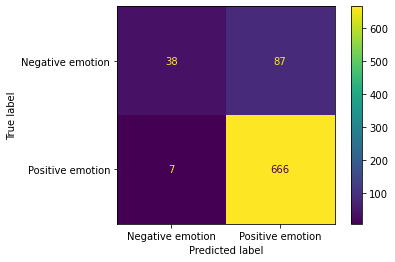

In [146]:
plot_confusion_matrix(etcgrid.best_estimator_, X_test_vec, y_test)

In [148]:
y_pred_gs = etcgrid.best_estimator_.predict(X_test_vec)

In [174]:
accuracy_score(y_test, y_pred_gs)

0.8822055137844611

In [155]:
from sklearn.metrics import classification_report

In [160]:
print("ExtraTrees gridsearch", classification_report(y_test, y_pred_gs))

ExtraTrees                   precision    recall  f1-score   support

Negative emotion       0.84      0.30      0.45       125
Positive emotion       0.88      0.99      0.93       673

        accuracy                           0.88       798
       macro avg       0.86      0.65      0.69       798
    weighted avg       0.88      0.88      0.86       798



In [161]:
print("ExtraTrees", classification_report(y_test, y_pred_etc))

ExtraTrees                   precision    recall  f1-score   support

Negative emotion       0.81      0.37      0.51       125
Positive emotion       0.89      0.98      0.94       673

        accuracy                           0.89       798
       macro avg       0.85      0.68      0.72       798
    weighted avg       0.88      0.89      0.87       798



In [166]:
print("SGD", classification_report(y_test, sgd_pred_test))

SGD                   precision    recall  f1-score   support

Negative emotion       0.67      0.16      0.26       125
Positive emotion       0.86      0.99      0.92       673

        accuracy                           0.86       798
       macro avg       0.76      0.57      0.59       798
    weighted avg       0.83      0.86      0.82       798



In [171]:
print("NB", classification_report(y_test, mnb_pred))

NB                   precision    recall  f1-score   support

Negative emotion       0.61      0.31      0.41       125
Positive emotion       0.88      0.96      0.92       673

        accuracy                           0.86       798
       macro avg       0.75      0.64      0.67       798
    weighted avg       0.84      0.86      0.84       798

